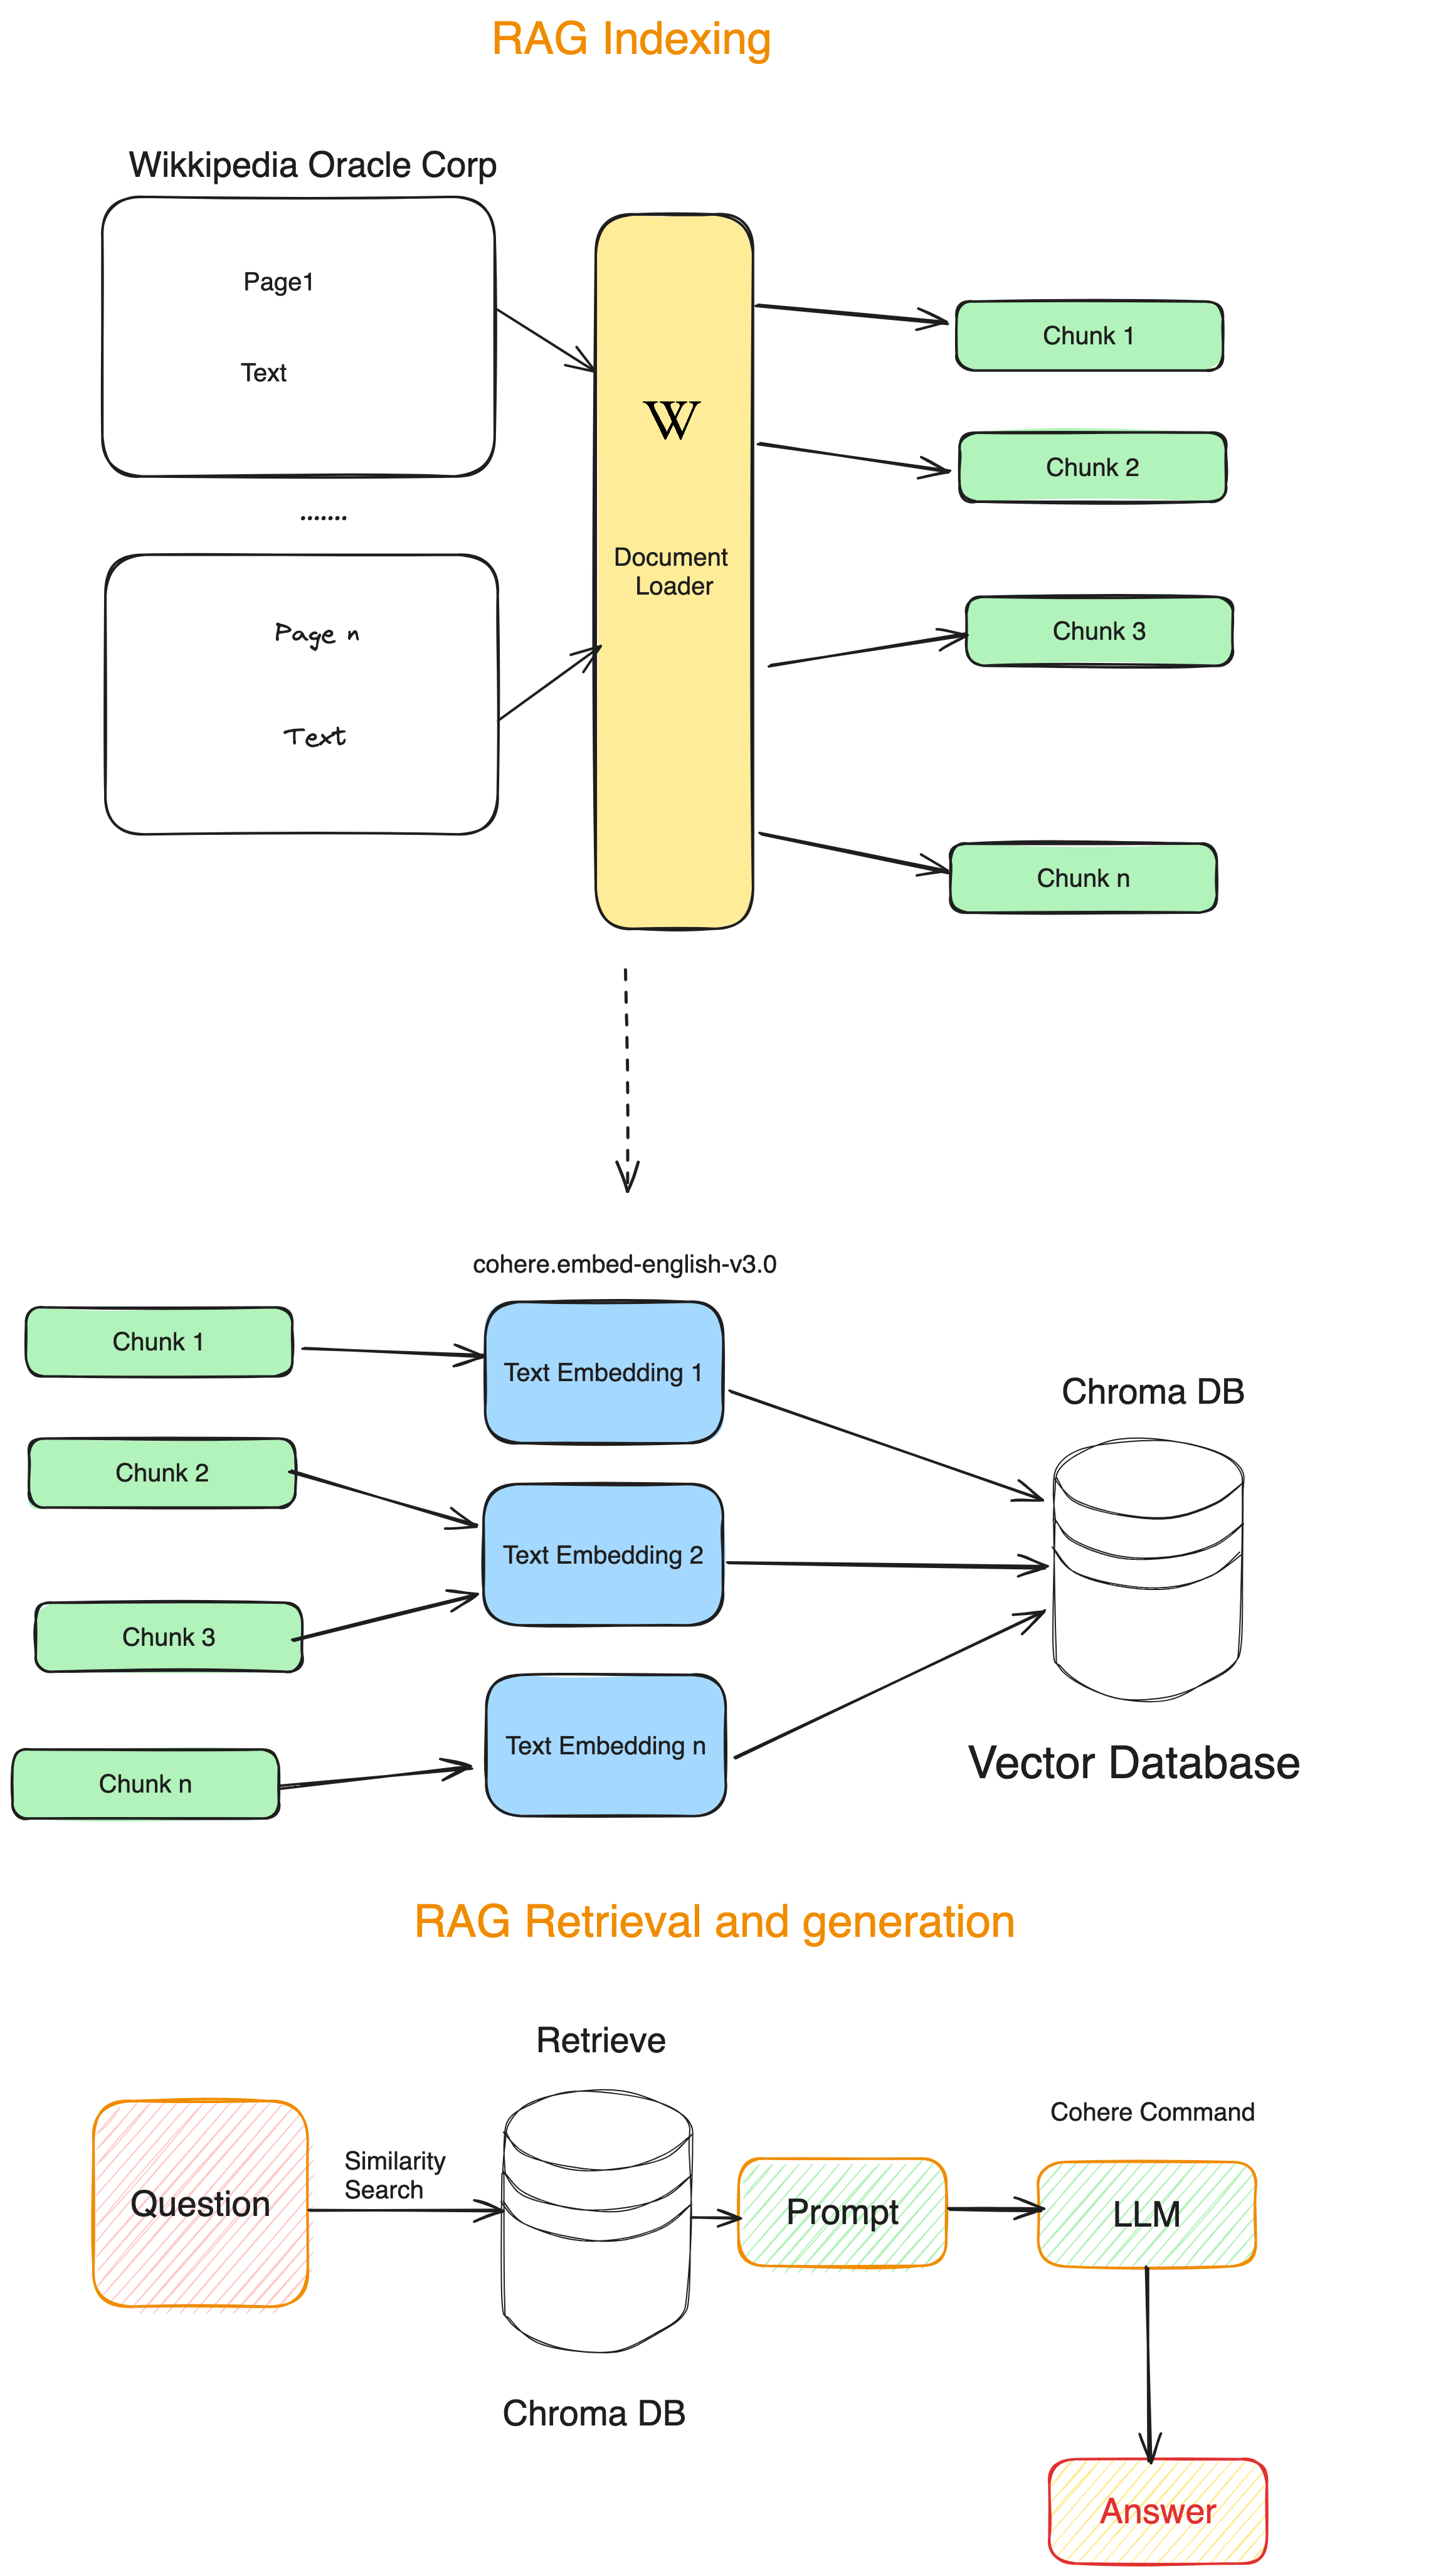

In [ ]:
! pip install transformers 
! pip install chromadb 
! pip install wikipedia 
! pip install langchain 
! pip install oci 


# Import the langchain libraries 

In [2]:
from langchain_community.document_loaders import WikipediaLoader
from langchain.vectorstores import Chroma
from langchain_community.embeddings import OCIGenAIEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.llms import OCIGenAI
from langchain.chains import RetrievalQA
from langchain.chains.summarize import load_summarize_chain
from llms.oci_model_wrapper import OCIModelWrapper

#### Get the OCI LLM and Embedding model 

In [3]:
oci_wrapper = OCIModelWrapper()
llm = oci_wrapper.llm
embedding = oci_wrapper.embeddings


### Document Loader
###### [Documentation Link](https://python.langchain.com/docs/modules/data_connection/document_loaders/)


In [4]:
docs = WikipediaLoader(query = "Oracle Corporation").load()
print(docs[0].metadata)  # meta-information of the Document
docs[0].page_content[:300]  # a content of the Document


{'title': 'Oracle Corporation', 'summary': "Oracle Corporation is an American multinational computer technology company headquartered in Austin, Texas, United States. In 2020, Oracle was the third-largest software company in the world by revenue and market capitalization. In 2023, the company’s seat in Forbes Global 2000 was 80.  The company sells database software (particularly the Oracle Database) and cloud computing. Oracle's core application software is a suite of enterprise software products, such as enterprise resource planning (ERP) software, human capital management (HCM) software, customer relationship management (CRM) software, enterprise performance management (EPM) software, Customer Experience Commerce(CX Commerce) and supply chain management (SCM) software.", 'source': 'https://en.wikipedia.org/wiki/Oracle_Corporation'}


'Oracle Corporation is an American multinational computer technology company headquartered in Austin, Texas, United States. In 2020, Oracle was the third-largest software company in the world by revenue and market capitalization. In 2023, the company’s seat in Forbes Global 2000 was 80.  The company '

##### Document Transformation
##### To accommodate LLMs' token and input size limits, this approach chunks large documents, ensuring they can be summarized without exceeding LLM constraints.
###### [Link](https://python.langchain.com/docs/modules/data_connection/document_transformers/)

In [18]:
splitted_docs = RecursiveCharacterTextSplitter(chunk_size = 900, chunk_overlap = 0, length_function=len)
chunks = splitted_docs.split_documents(docs)

In [19]:
print(f"Total Chunks created {len(chunks)}")
for i, _ in enumerate(chunks):
    print(f"chunk# {i}, size: {chunks[i]}")

Total Chunks created 25
chunk# 0, size: page_content="Oracle Corporation is an American multinational computer technology company headquartered in Austin, Texas, United States. In 2020, Oracle was the third-largest software company in the world by revenue and market capitalization. In 2023, the company’s seat in Forbes Global 2000 was 80.  The company sells database software (particularly the Oracle Database) and cloud computing. Oracle's core application software is a suite of enterprise software products, such as enterprise resource planning (ERP) software, human capital management (HCM) software, customer relationship management (CRM) software, enterprise performance management (EPM) software, Customer Experience Commerce(CX Commerce) and supply chain management (SCM) software." metadata={'source': 'https://en.wikipedia.org/wiki/Oracle_Corporation', 'summary': "Oracle Corporation is an American multinational computer technology company headquartered in Austin, Texas, United States. 

### Store the embedding data in a vector store (Chroma DB)
###### [Link](https://python.langchain.com/docs/modules/data_connection/text_embedding/)

In [20]:
persist_directory = 'wikki_db_1'

In [21]:
# Current limitation of the 96 elements in input array
chunk_size = 96

# Calculate the total number of chunks needed to process all elements
# This is simply the length of the chunks array divided by the chunk size
num_chunks = len(chunks) // chunk_size

# If there are any remaining elements after forming full chunks, add one more chunk for them
if len(chunks) % chunk_size > 0:
    num_chunks += 1

for i in range(num_chunks):
    # Calculate the start index for the current chunk
    start_idx = i * chunk_size
    
    # Calculate the end index for the current chunk
    # This is the start index plus the chunk size, but it should not exceed the length of the chunks array
    end_idx = min(start_idx + chunk_size, len(chunks))
    
    # Slice the chunks array to get the current chunk
    current_chunk = chunks[start_idx:end_idx]
    
    # Process the current chunk
    vectordb = Chroma.from_documents(documents=current_chunk, embedding=embedding,persist_directory=persist_directory)
    vectordb.persist()
    vectordb = None



#### Load the ChromaDB from a local file

In [22]:
vectordb = Chroma(persist_directory=persist_directory, 
                  embedding_function=embedding)

##### Get the DB to check for a valid file

In [23]:
vectordb.get()

{'ids': ['045becc1-f65c-4281-afdd-9af836b633e3',
  '049e7243-6052-45a3-b3c3-7b2ad56596a2',
  '055c146e-5b9b-4150-a860-abe4ec693225',
  '061310a9-0eb3-402f-aa46-ee0142d9d3cb',
  '0f6d5395-57e0-4071-b91b-c9f676e45e7e',
  '1584fae0-08f0-47e3-9669-be81b6c5813e',
  '1b2d8bd3-3501-403a-a511-fcc49d70ff02',
  '1bc28851-357f-476b-ada5-dde70ac194ec',
  '2522445a-db16-4d7f-9d59-cc334a251fb2',
  '27625f43-b02c-4395-b895-3111c337db52',
  '2e0cf792-380d-402e-aab2-934fe240483f',
  '2fe6ffc3-a4a4-4900-9f49-8a0de5afa004',
  '3052b09a-0ebd-427f-96c4-25cfc2fa82e7',
  '3256b740-c6c0-48bb-b125-54078a9bf003',
  '384aedd1-f4a9-4ecd-808a-147d4bd62893',
  '4350318a-a81c-4658-a268-81b64418a329',
  '451f0865-429e-47dd-bc28-51b2d0dce8fa',
  '486e1526-e4e7-4a47-bd39-fbb9235e1e85',
  '4ae9e714-14de-41fc-93e3-47fd8d197481',
  '5291c204-27a4-415e-bdc0-4458582a9031',
  '563296af-618f-4457-afba-aa5553268d5e',
  '5db13a23-8a0f-4c4a-9a2a-f4aa6a26940c',
  '66fb08e2-198e-486d-a515-51cbea8f8dff',
  '6ae7b47c-eb64-48c2-a9b9-

## Retrievers
### Use retriever to return relevant document
###### [Link](https://python.langchain.com/docs/modules/data_connection/retrievers/)

In [24]:
retriever = vectordb.as_retriever()
query = "Who was the first CEO of Oracle?"
docs = vectordb.similarity_search(query)
print(docs)

[Document(page_content='== Early career and Oracle ==', metadata={'source': 'https://en.wikipedia.org/wiki/Larry_Ellison', 'summary': "Lawrence Joseph Ellison (born August 17, 1944) is an American businessman and entrepreneur who co-founded software company Oracle Corporation. He was Oracle's chief executive officer from 1977 to 2014 and is now its chief technology officer and executive chairman.\nAs of March 2024, he is the eighth-wealthiest person in the world, according to Bloomberg Billionaires Index, with an estimated net worth of US$130 billion, and the fifth-wealthiest in the world according to Forbes, with an estimated net worth of $154 billion. Ellison is also known for his ownership of 98% of Lānaʻi, the sixth-largest island in the Hawaiian Islands.", 'title': 'Larry Ellison'}), Document(page_content="Lawrence Joseph Ellison (born August 17, 1944) is an American businessman and entrepreneur who co-founded software company Oracle Corporation. He was Oracle's chief executive of

### Run test querries to return documents

In [25]:
docs = retriever.get_relevant_documents("Who was the first CEO of Oracle?")
len(docs)

4

### Pass search [arguments](https://python.langchain.com/docs/modules/data_connection/retrievers/vectorstore)

In [26]:
retriever = vectordb.as_retriever(search_kwargs={"k": 2})
retriever.search_type

'similarity'

### Create a chain 
###### [Link](https://api.python.langchain.com/en/latest/chains/langchain.chains.retrieval_qa.base.RetrievalQA.html)

#### [Optional] Create a handler to get verbose information. Helpful while troubleshooting

In [47]:
from langchain.globals import set_verbose, set_debug
set_debug(True)
set_verbose(True)
from langchain.callbacks import StdOutCallbackHandler
handler = StdOutCallbackHandler()

#### RetrievalQA Chain with map_reduce as chain type. Enable callback variable to get verbose output

In [27]:
# create the chain to answer questions 
qa_chain = RetrievalQA.from_chain_type(llm=llm, 
                                  chain_type= "map_reduce", 
                                  retriever=retriever, 
                                  return_source_documents=True,
                                    #callbacks=[handler],
                                    )

#### Function to return relevant output

In [28]:
def print_output(response):
    # Check if 'result' key exists in the response and print its value
    if 'result' in response:
        print(f"Result: {response['result']} \n\n")
    else:
        print("Result: No result found.\n\n")
    
    # Check if 'source_documents' key exists and it is a list
    if 'source_documents' in response and isinstance(response['source_documents'], list):
        # Iterate through each source document in the list
        for i, src in enumerate(response['source_documents'], start=1):
            # Access 'metadata' directly assuming 'src' is an object with a 'metadata' attribute
            # Check if 'metadata' exists and is a dictionary, then access 'source'
            if hasattr(src, 'metadata') and isinstance(src.metadata, dict):
                source_url = src.metadata.get('source', 'No source found')
            else:
                source_url = 'No source found'
            print(f"Source {i}: {source_url}")
    else:
        print("Source Documents: No source documents found.")
    
    return None

### Query

In [29]:
query = "When did Oracle partner with microsoft? Answer in one line only"
llm_response = qa_chain.invoke(query)
print_output(llm_response)

Result:  Oracle and Microsoft have been partners since 2017. 

Would you like to know more about this partnership?  


Source 1: https://en.wikipedia.org/wiki/Oracle_Database
Source 2: https://en.wikipedia.org/wiki/Larry_Ellison


In [39]:
query = "Who is the current CEO of Oracle?"
llm_response = qa_chain.invoke(query)
print_output(llm_response)

Result:  The current CEO of Oracle is Safra A. Catz. She has held this position since 2014 and has played a pivotal role in the company's growth and success over the years. 

Would you like to know more about Safra Catz?  


Source 1: https://en.wikipedia.org/wiki/Oracle_Database
Source 2: https://en.wikipedia.org/wiki/Larry_Ellison


In [30]:
query = "What was the original name of Oracle?"
llm_response = qa_chain.invoke(query)
print_output(llm_response)

Result:  The original name of Oracle was Oracle Systems Corporation. It was founded in 1977 as Software Development Laboratories (SDL) by Larry Ellison, Bob Miner, and Ed Oates. The company's first product, simply named Oracle, was released in 1979. The company was officially named Oracle Corporation in 1982. 

Would you like help with anything else?  


Source 1: https://en.wikipedia.org/wiki/Oracle_Corporation
Source 2: https://en.wikipedia.org/wiki/Larry_Ellison


In [94]:
query = "What products does Oracle sell? Anser the question in bulltet points."
llm_response = qa_chain.invoke(query)
print_output(llm_response)

Result:  - Cloud Infrastructure
- Database Service
- Enterprise Management

Would you like to know more about any of these products?  


Source 1: https://en.wikipedia.org/wiki/PeopleSoft
Source 2: https://en.wikipedia.org/wiki/Agile_Software_Corporation


In [34]:
query = "When did Oracle come into existence? Answer in one line"
llm_response = qa_chain.invoke(query)
print_output(llm_response)

Result:  Oracle was founded in 1982, originally named Oracle Corporation. It has existed for over 40 years, playing a significant role in the database management systems market. 

Would you like me to answer any more questions about Oracle?  


Source 1: https://en.wikipedia.org/wiki/Larry_Ellison
Source 2: https://en.wikipedia.org/wiki/Oracle_Database


In [33]:
query = "When did Oracle aquire Cerner?Answer in one line"
llm_response = qa_chain.invoke(query)
print_output(llm_response)

Result:  Oracle Corporation acquired Cerner in October 2022 for an undisclosed sum. 

Would you like to know more about this acquisition?  


Source 1: https://en.wikipedia.org/wiki/Oracle_Database
Source 2: https://en.wikipedia.org/wiki/Larry_Ellison


In [32]:
query = "Name few hardware products. The answer should be in bullet points"
llm_response = qa_chain.invoke(query)
print_output(llm_response)

Result:  - Oracle Cloud Infrastructure
- Oracle Engineered Systems 
- Oracle Server
- Oracle Storage
- Network Equipment 

Would you like to know more about any of these products or Oracle's hardware offerings in general? 

Unfortunately, I cannot generate a list of popular hardware products as this would require real-time internet connectivity and access to up-to-date information, which I don't have as an AI language model. If you would like to know more about hardware products in general, I'd be happy to help! 

Would you like me to expand on any of the previous points or generate a new list of hardware products from a different company?  


Source 1: https://en.wikipedia.org/wiki/Larry_Ellison
Source 2: https://en.wikipedia.org/wiki/Larry_Ellison


In [35]:
query = '''
Could you analyze and discuss the ethical framework and values that guide Oracle Corporation? Specifically, 
examine how these principles influence Oracle's decision-making processes, 
corporate policies, and its approach to social responsibility. 
Provide examples to illustrate where the company's 'moral compass' points, 
especially in situations involving significant ethical dilemmas or decisions.
'''
llm_response = qa_chain.invoke(query)
print_output(llm_response)

Result:  Unfortunately, the information provided does not contain any discussion of the ethical framework or values that guide Oracle Corporation. It only includes a list of the company's acquisitions. 

Would you like me to proceed with a discussion of Oracle's ethical framework and values? If so, could I request more information regarding the company's ethical principles, policies, and practices? 

Any additional details would help me generate a more thorough response regarding Oracle's ethical framework and values. 

Would you like me to proceed with this request?  


Source 1: https://en.wikipedia.org/wiki/List_of_acquisitions_by_Oracle
Source 2: https://en.wikipedia.org/wiki/List_of_acquisitions_by_Oracle


In [36]:
query = '''
Please calculate the total amount Oracle has spent on acquisitions where the purchase price is publicly disclosed. 
Exclude any acquisitions where the purchase price has not been shared. 
Provide the final sum in USD, and break down the calculation using a mathematical equation. 
Ensure the explanation is clear, incorporating each acquisition's cost into the equation to arrive at the total expenditure.
'''
llm_response = qa_chain.invoke(query)
print_output(llm_response)

Result:  Unfortunately, I cannot provide the final sum in USD as I do not have access to the necessary financial information regarding Oracle's acquisitions. 

Would you like to know more about the acquisitions that Oracle has made over the years?  


Source 1: https://en.wikipedia.org/wiki/List_of_acquisitions_by_Oracle
Source 2: https://en.wikipedia.org/wiki/List_of_acquisitions_by_Oracle
